In [15]:
from datetime import datetime
import pandas as pd

X_station_train_df = pd.read_csv("../../Hackathon/Train/X_station_train.csv", index_col=["Id"])

In [16]:
def transform_station(df):
    
    def year(row):
        _dtime = row['dtime']
        return _dtime.year

    def month(row):
        _dtime = row['dtime']
        return _dtime.month
    
    def day(row):
        _dtime = row['dtime']
        return _dtime.day

    def hour(row):
        _dtime = row['dtime']
        return _dtime.hour

    df['dtime'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
    df['year'] = df.apply(lambda row: year(row), axis = 1)
    df['month'] = df.apply(lambda row: month(row), axis = 1)
    df['day'] = df.apply(lambda row: day(row), axis = 1)
    df['hour'] = df.apply(lambda row: hour(row), axis = 1)
    
    return df

In [17]:
X_station_train_df = transform_station(X_station_train_df)

In [18]:
X_station_train_df.head()

,number_sta,date,ff,t,td,hu,dd,precip,dtime,year,month,day,hour
Id,,,,,,,,,,,,,
14066001_0_0,14066001,2016-01-01 00:00:00,3.05,279.28,277.97,91.4,200.0,0.0,2016-01-01 00:00:00,2016,1,1,0
14066001_0_1,14066001,2016-01-01 01:00:00,2.57,278.76,277.45,91.4,190.0,0.0,2016-01-01 01:00:00,2016,1,1,1
14066001_0_2,14066001,2016-01-01 02:00:00,2.26,278.27,277.02,91.7,181.0,0.0,2016-01-01 02:00:00,2016,1,1,2
14066001_0_3,14066001,2016-01-01 03:00:00,2.62,277.98,276.95,93.0,159.0,0.0,2016-01-01 03:00:00,2016,1,1,3
14066001_0_4,14066001,2016-01-01 04:00:00,2.99,277.32,276.72,95.9,171.0,0.0,2016-01-01 04:00:00,2016,1,1,4


In [51]:
station_df = X_station_train_df[X_station_train_df['number_sta']==14066001]

def precip(month,day):
    station_14066001_ex = station_df[station_df['year']==2016][station_df['month']==month][station_df['day']==day]
    return station_14066001_ex['precip'].values

In [55]:
import matplotlib.pyplot as plt
import numpy as np

/tmp/ipykernel_27773/1030383031.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  station_14066001_ex = station_df[station_df['year']==2016][station_df['month']==month][station_df['day']==day]


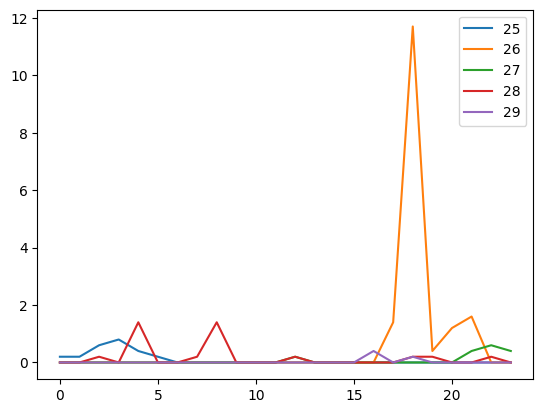

In [79]:
for i in range(25,30):
    p = precip(3,i)
    plt.plot(np.arange(24),p, label=i)
    plt.legend()

/tmp/ipykernel_27773/1030383031.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  station_14066001_ex = station_df[station_df['year']==2016][station_df['month']==month][station_df['day']==day]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


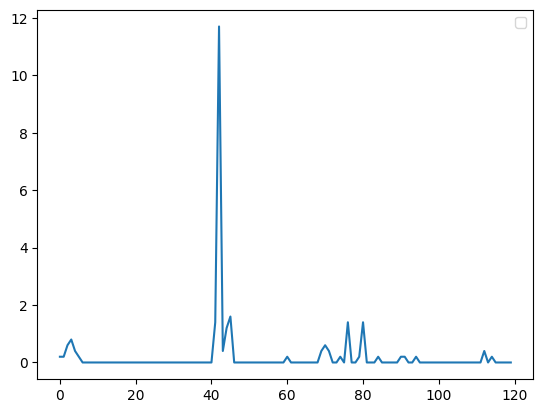

In [85]:
L = []
for i in range(25,30):
    p = precip(3,i)
    for j in p:
        L.append(j)

plt.plot(np.arange(len(L)),L)
plt.legend()